# Best time to release review after tech event

In [39]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import datetime
import matplotlib.pyplot as plt
import pickle
import datetime

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from gensim import corpora, models
import gensim
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')

In [3]:
PATH_YT_METADATA = 'data/yt_metadata_en.jsonl'
ITEMS = ['iphone x', 'iphone 7', 'iphone 6', 'galaxy s9', 'galaxy note 9', 'galaxy fold']
RELEASE_DATES = {
    'iphone x': '2017-11-03',
    'iphone 7': '2016-09-16',
    'iphone 6': '2014-09-19',
    'galaxy s9': '2018-03-16',
    'galaxy note 9': '2018-08-24',
    'galaxy fold': '2019-02-01'
}

In [11]:
items_dfs = {k : [] for k in ITEMS}

In [12]:
# filter metadata
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date", "display_id", "tags"], inplace=True, axis=1)
    df_json = df_json[df_json['categories'].isin(['Science & Technology', 'Education', 'Entertainment'])]
    df_json.drop(["categories"], inplace=True, axis=1)
    for item in ITEMS:
        df_item = df_json[df_json['title'].str.lower().str.contains(item)]
        df_item["upload_date"] = pd.to_datetime(df_item["upload_date"])
        df_item = df_item[(df_item['upload_date'] >= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') - datetime.timedelta(days=180)) & (df_item['upload_date'] <= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') + datetime.timedelta(days=180))]
        if len(df_item) > 0:
            items_dfs[item].append(df_item)

Loading data: 730it [08:59,  1.35it/s]                               


In [13]:
items_dfs = {k : pd.concat(v) for k, v in items_dfs.items()}

In [23]:
def get_sum_views(df):
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df["upload_date"] = df["upload_date"].dt.date

    # remove rows with NaN
    df = df.dropna()


    # convert 'view_count' to int64
    df["view_count"] = df["view_count"].astype("int64")

    # keep only 'view_count' and 'upload_date'
    df = df[["view_count", "upload_date"]]
    df = df.groupby("upload_date").sum()

    # remove rows with NaN
    df = df.dropna()
    
    return df

In [24]:
def plot_views_per_day(df, item):
    plt.figure(figsize=(20,10))
    plt.bar(df.index, df["view_count"])
    plt.xlabel("Date")
    plt.ylabel("View Count")
    plt.title("{item} View Count Over Time".format(item=item))
    plt.show()

In [25]:
def tf_idf(tokens):
    """
    Given a list of tokens, compute the tf-idf coefficient for each token.
    :param tokens: list of titles split into tokens
    :return: dictionary of tf-idf coefficients
    """
    # create dictionary
    dictionary = corpora.Dictionary(tokens)
    
    # create corpus
    corpus = [dictionary.doc2bow(text) for text in tokens]
    
    # create tf-idf model
    tfidf = models.TfidfModel(corpus)
    
    # get tf-idf coefficients
    tfidf_weights = {}
    for doc in corpus:
        for id, weight in tfidf[doc]:
            tfidf_weights[dictionary[id]] = weight
    
    return tfidf_weights

In [26]:
def get_tf_idf_score(tf_idf_scores, words):
    """
    Given a dictionary of tf-idf scores and a list of words, compute the average tf-idf score for the list of words.
    :param tf_idf_scores: dictionary of tf-idf scores
    :param words: list of words
    :return: average tf-idf score for the list of words
    """
    score = 0
    for word in words:
        score += tf_idf_scores.get(word, 0)

    return score / len(words)

In [27]:
def score_per_day(df, item, release_date):
    """
    Given a product name, fetches the df for videos with titles containing the name of the product
    that were uploaded within 6 months of the product's release date and computes the total view count,
    total likes total dislikes and number of videos per day.
    :param item: product name
    :param df: dataframe of videos with titles containing the name of the product
    :return: dataframe of total view count, total likes total dislikes and number of videos per day
    """

    # filter out titles that do not contain the product name
    df = df[df["title"].str.lower().str.contains(item)]
    
    # convert 'view_count' to int
    df["view_count"] = df["view_count"].astype(int)

    # convert 'upload_date' to datetime
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df["upload_date"] = df["upload_date"].dt.date

    # keep only rows that were uploaded within 3 months of the product's release date
    df = df[(df["upload_date"] >= release_date - datetime.timedelta(days=90)) & (df["upload_date"] <= release_date + datetime.timedelta(days=90))]

    # keep only 'view_count', 'upload_date', 'likes', 'dislikes', 'title'
    df = df[["view_count", "upload_date", "like_count", "dislike_count", "title"]]

    # group by 'upload_date'
    df = df.groupby("upload_date")

    # compute total view count, total like_count, total dislike_count and number of videos per day
    df = df.agg({"view_count": "sum", "like_count": "sum", "dislike_count": "sum", "title": "count"})

    return df

In [28]:
def plot_scores(scores_df, release_date, product_name):
    """
    Given a dataframe of view count, like count, dislike count and number of videos per day,
    plots the view count, like count, dislike count and number of videos per day over time.
    :param scores_df: dataframe of view count, like count, dislike count and number of videos per day
    :return: None
    """

    # plot the 4 curves in 4 subplots as bar graphs and for each subplot put a vertical dotted line at the release date
    fig, axs = plt.subplots(3, figsize=(20, 20))
    axs[0].bar(scores_df.index, scores_df["view_count"])
    axs[0].set_title("View Count Over Time")
    axs[0].axvline(x=release_date, color="red", linestyle="--")
    
    axs[1].bar(scores_df.index, scores_df["title"])
    axs[1].set_title("Number of Videos Over Time")
    axs[1].axvline(x=release_date, color="red", linestyle="--")

    axs[2].bar(scores_df.index, scores_df["view_count"] / scores_df["title"])
    axs[2].set_title("Average Views Per Video Over Time")
    axs[2].axvline(x=release_date, color="red", linestyle="--")
    

    # give a big title to the entire figure
    fig.suptitle("Scores Over Time for {product_name}".format(product_name=product_name), fontsize=30)
    plt.show()


In [29]:
def get_lda_topics(df, num_topics, num_words):
    # tokenize words
    tokenizer = RegexpTokenizer(r'\w+')
    df["tokens"] = df["title"].apply(tokenizer.tokenize)

    # convert to lowercase
    df["tokens"] = df["tokens"].apply(lambda x: [word.lower() for word in x])
    
    # remove stop words
    stop_words = stopwords.words('english')
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in stop_words])
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    df["tokens"] = df["tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # remove words that appear only once
    all_tokens = sum(df["tokens"], [])
    tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in tokens_once])

    # remove the token 'iphone'
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word != "iphone"])

    # remove one character tokens
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if len(word) > 2])
    
    # create dictionary and corpus
    dictionary = corpora.Dictionary(df["tokens"])
    corpus = [dictionary.doc2bow(text) for text in df["tokens"]]
    
    # create LDA model
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    
    # print topics
    print("LDA Topics:")
    for topic in lda.print_topics(num_words=num_words):
        print(topic)
    
    # visualize topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    return vis

***
## 1- Impact of iPhone release on Youtube activity
***

### 1.1- iPhone X views vs YouTube views

In [19]:
yt_date_views = {}
iphone_date_views = {}
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date", "display_id", "tags", "categories"], inplace=True, axis=1)

    item1 = 'iphone x'
    item2 = 'wwdc'

    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[(df_json['upload_date'] >= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') - datetime.timedelta(days=180)) & (df_json['upload_date'] <= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') + datetime.timedelta(days=180))]

    # filter out titles that do not contain item1 or item2
    df_item = df_json[df_json["title"].str.lower().str.contains(item1) | df_json["title"].str.lower().str.contains(item2)]

    item_views = get_sum_views(df_item)
    youtube_views = get_sum_views(df_json)

    # for each 'upload_date' in item_views, get the corresponding 'view_count' in youtube_views
    for date in item_views.index:
        if date in yt_date_views:
            yt_date_views[date] += youtube_views.loc[date]["view_count"]
            iphone_date_views[date] += item_views.loc[date]["view_count"]
        else:
            yt_date_views[date] = youtube_views.loc[date]["view_count"]
            iphone_date_views[date] = item_views.loc[date]["view_count"]

Loading data: 730it [11:16,  1.08it/s]                                 


In [20]:
# convert dictionaries to dataframes
yt_date_views_df = pd.DataFrame.from_dict(yt_date_views, orient="index", columns=["view_count"])
iphone_date_views_df = pd.DataFrame.from_dict(iphone_date_views, orient="index", columns=["view_count"])

In [21]:
# get the ratio of iphone views to youtube views
iphone_date_views_df["ratio"] = iphone_date_views_df["view_count"] / yt_date_views_df["view_count"]

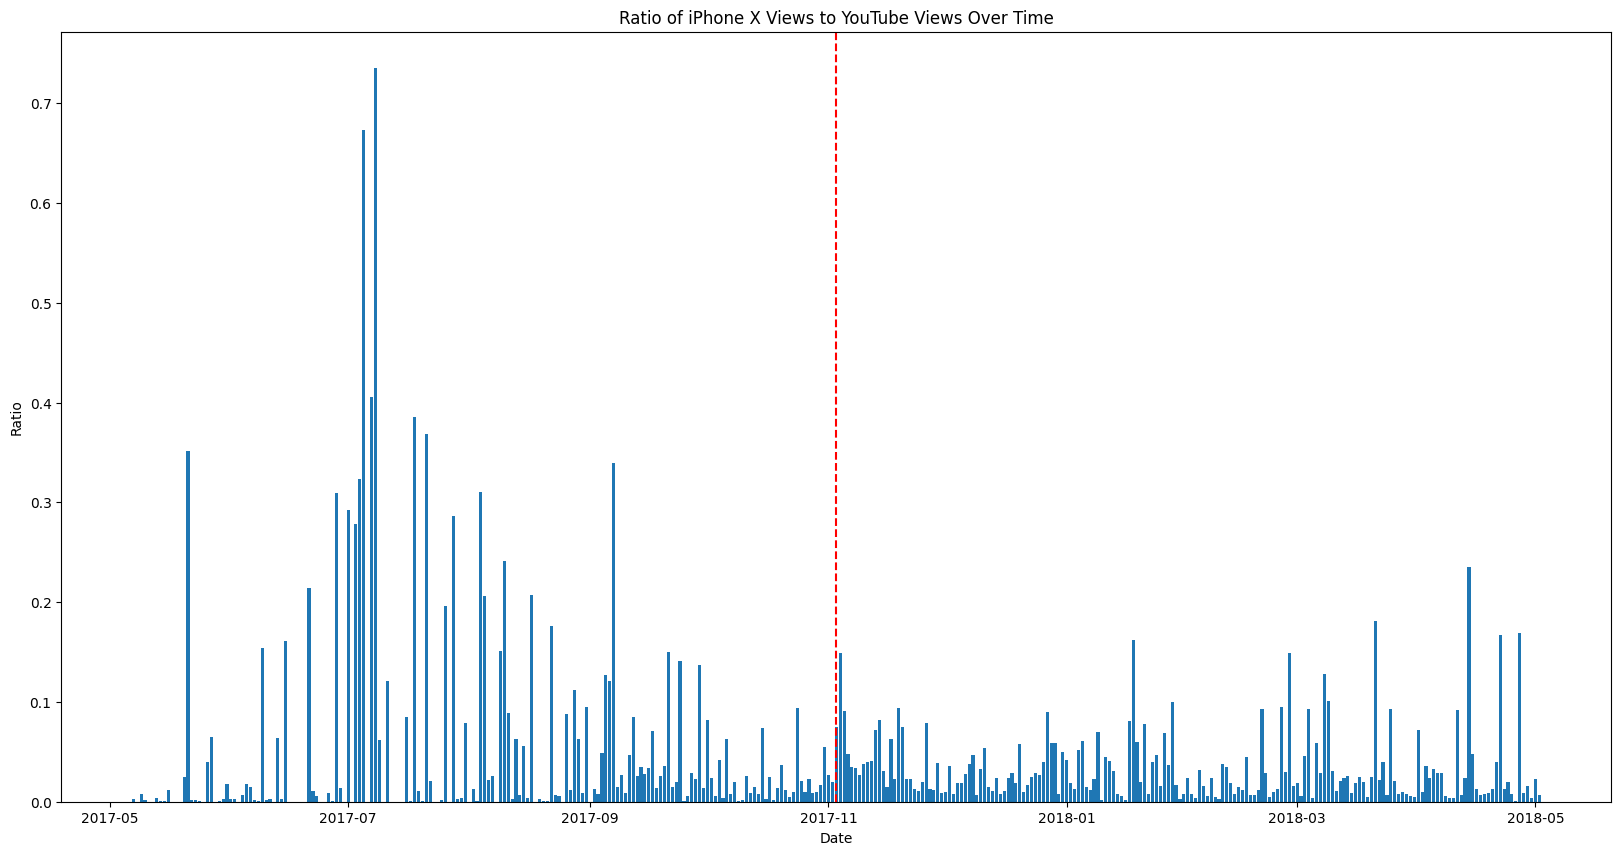

In [22]:
# plot the ratio over time
release_date = datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date()
plt.figure(figsize=(20,10))
plt.bar(iphone_date_views_df.index, iphone_date_views_df["ratio"])
plt.axvline(x=release_date, color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.title("Ratio of iPhone X Views to YouTube Views Over Time")
plt.show()


As we can see from the above plot, July 2017, September 2017 and November 2017 are all months with very high user interaction with videos about the iPhone.\
Indeed, in July, upwards of 70% of total views on the platfrom were directed towards videos about the iPhone.\
40%, in September and 15% in November.\
These months are all important with respect to the iPhone X, in fact, July 2017 came just after WWDC 2017, meaning that rumors about the iPhone X were starting to spread.\
September 2017 is the month where iPhone X was announced and November 2017 is the month where the iPhone X was released.\
We can thus conclude that the Youtube platform is most active around one month before the release of a product and at the time of its release.

### 1.2- Number of videos released about iPhone X and views generated

In [33]:
with open('data/yt_tech_metadata.pickle', 'rb') as f:
    items_dfs = pickle.load(f)

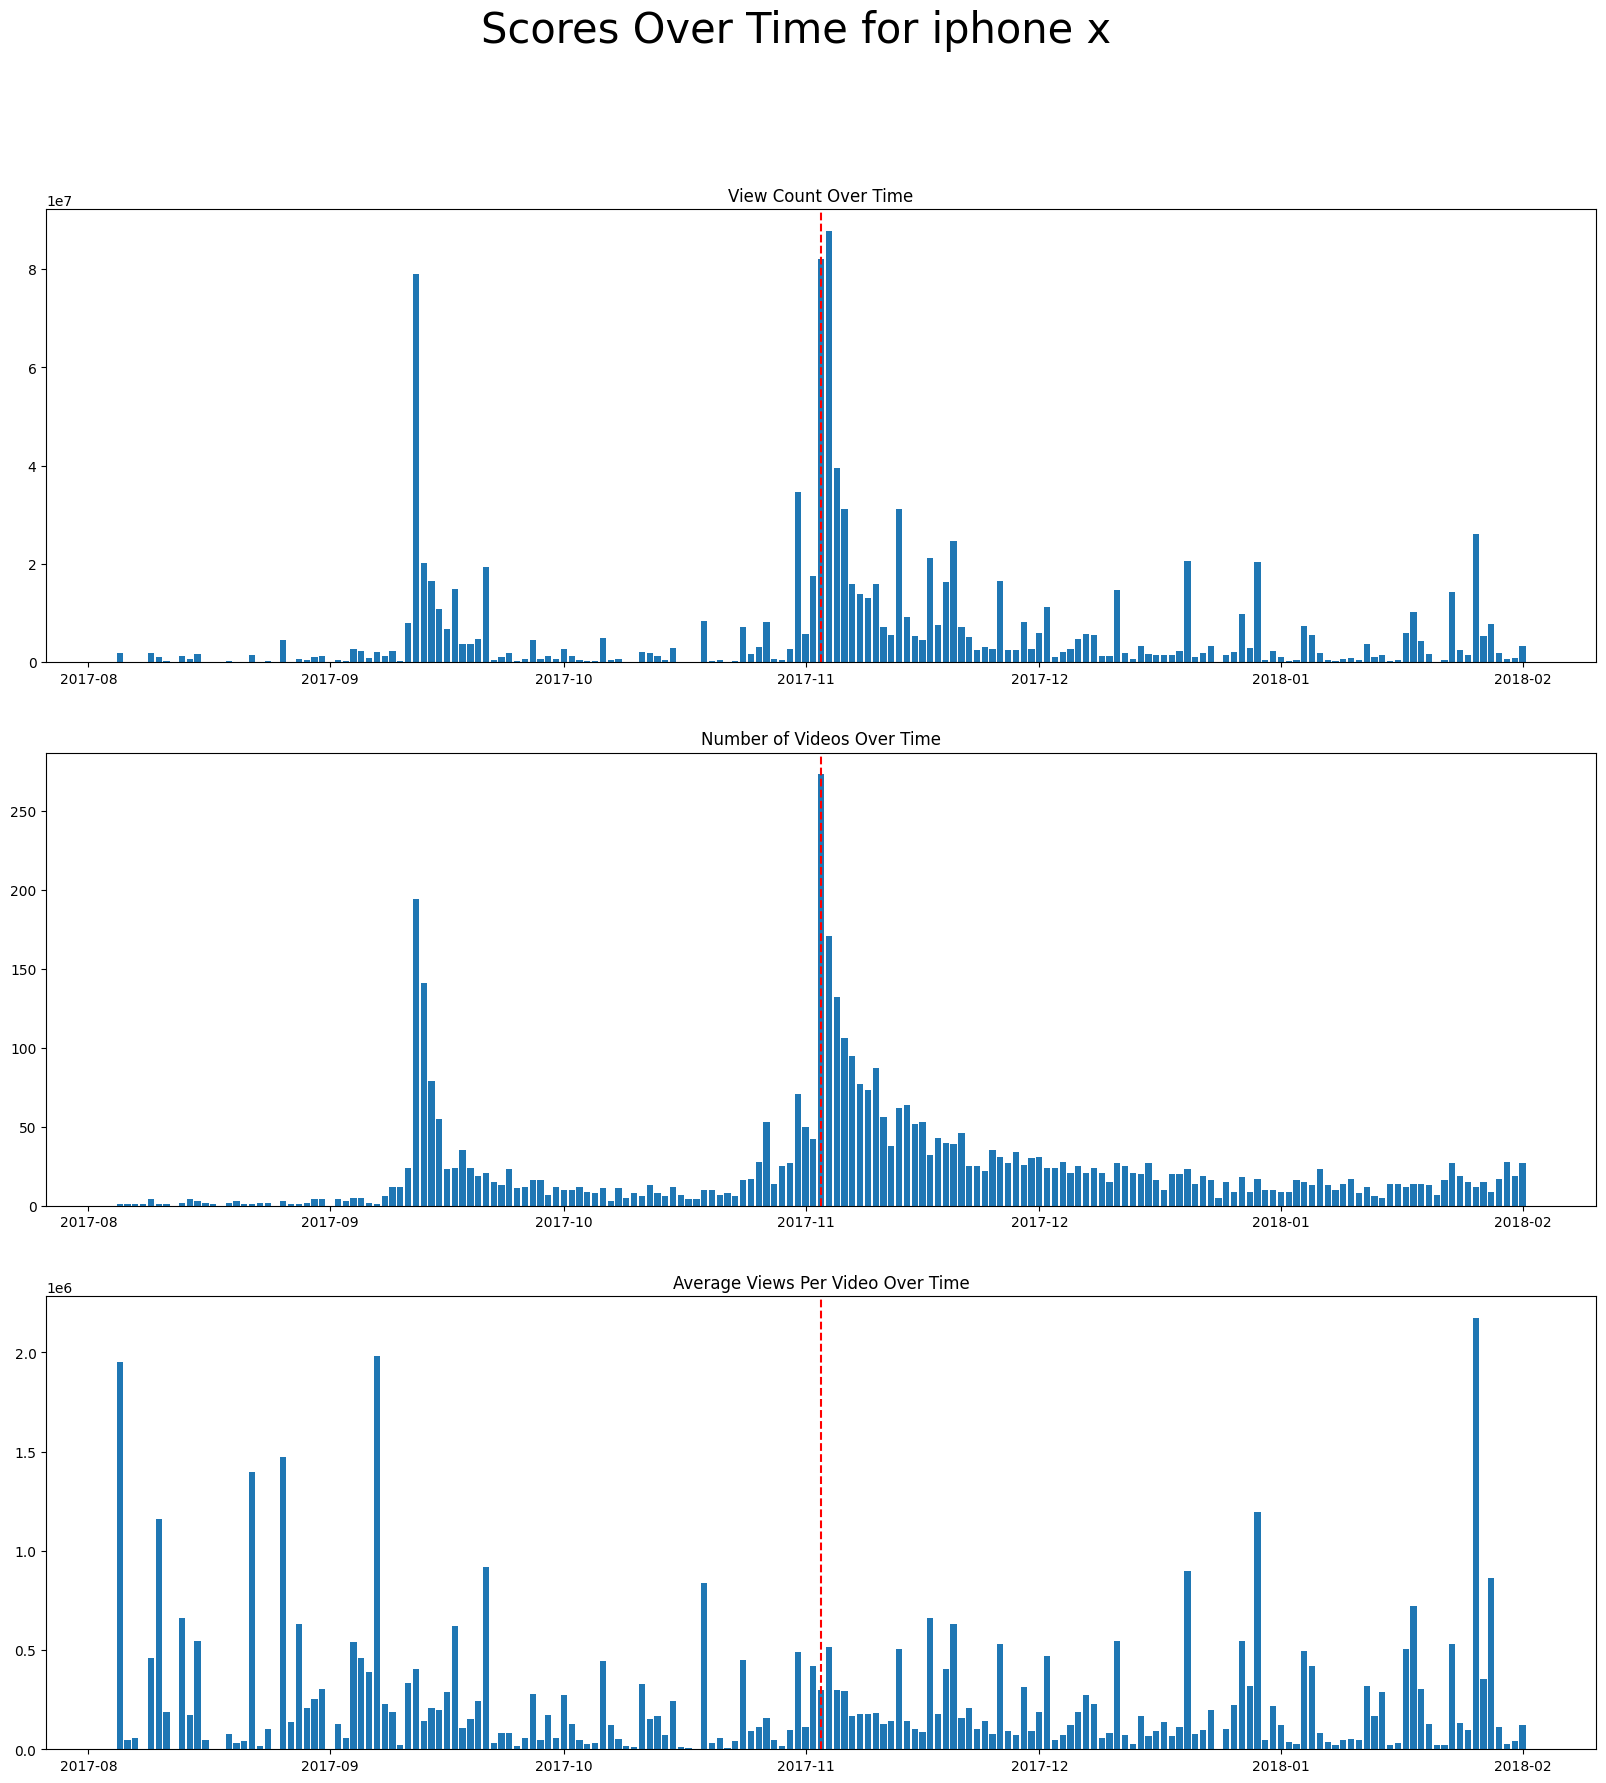

In [34]:
iphone_df = score_per_day(items_dfs['iphone x'], 'iphone x', datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date())
release_date = datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date()
plot_scores(iphone_df, release_date, 'iphone x')

We can once again clearly see once again that the number of views and videos released about the iPhone X reach peaks in September and November 2017.\
We can thus conclude that the Youtube platform is most active around one month before the release of a product and at the time of its release.\
Having concluded this, we would like to know what topics are the most discussed in the videos about the iPhone. during these two periods.

***
## 2- Topics discussed in videos about the iPhone
***

In [40]:
iphone_df = items_dfs['iphone x']
iphone_df["upload_date"] = pd.to_datetime(iphone_df["upload_date"])

# convert upload_date to date
iphone_df["upload_date"] = iphone_df["upload_date"].dt.date

pre_release = iphone_df[(iphone_df["upload_date"] <= release_date - datetime.timedelta(days=60))]
release = iphone_df[(iphone_df["upload_date"] >= release_date - datetime.timedelta(days=30)) & (iphone_df["upload_date"] <= release_date + datetime.timedelta(days=30))]

In [41]:
get_lda_topics(pre_release, 3, 10)

LDA Topics:
(0, '0.055*"feature" + 0.048*"leak" + 0.042*"plus" + 0.039*"download" + 0.035*"unboxing" + 0.030*"ringtone" + 0.029*"link" + 0.029*"free" + 0.023*"clone" + 0.022*"test"')
(1, '0.066*"hand" + 0.042*"leak" + 0.040*"color" + 0.036*"clone" + 0.034*"unboxing" + 0.030*"new" + 0.028*"prototype" + 0.028*"apple" + 0.027*"edition" + 0.022*"date"')
(2, '0.046*"hand" + 0.046*"leak" + 0.037*"clone" + 0.031*"galaxy" + 0.031*"final" + 0.031*"display" + 0.030*"unboxing" + 0.028*"note" + 0.028*"live" + 0.026*"rumor"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.011865 -0.062457       1        1  42.190579
2     -0.077274  0.037908       2        1  32.821958
0      0.089139  0.024549       3        1  24.987463, topic_info=        Term      Freq     Total Category  logprob  loglift
4    feature  7.000000  7.000000  Default  30.0000  30.0000
74  download  3.000000  3.000000  Default  29.0000  29.0000
84  ringtone  2.000000  2.000000  Default  28.0000  28.0000
83      link  2.000000  2.000000  Default  27.0000  27.0000
82      free  2.000000  2.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
15       new  1.065335  6.478940   Topic3  -4.2961  -0.4185
29     color  1.034653  6.626418   Topic3  -4.3253  -0.4702
2       note  0.997849  5.440867   Topic3  -4.3616  -0.3093
1     galaxy  0.971761  4.536603   Topic3  -4.3881  -0.1540
58    design  0.954169  3.970909   Topic3  -4.4063  -0.0391

[147 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
75        2  0.870110     1000
66        1  0.620093     2017
66        2  0.310047     2017
26        2  0.868622  android
43        1  0.557749    apple
...     ...       ...      ...
10        1  0.314078   weekly
10        2  0.314078   weekly
20        1  0.323373    white
20        3  0.646746    white
36        1  0.804182  working

[153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [37]:
get_lda_topics(release, 3, 10)

LDA Topics:
(0, '0.055*"unboxing" + 0.046*"review" + 0.040*"apple" + 0.022*"first" + 0.019*"impression" + 0.014*"samsung" + 0.013*"galaxy" + 0.013*"2017" + 0.012*"plus" + 0.010*"best"')
(1, '0.028*"unboxing" + 0.021*"test" + 0.020*"apple" + 0.020*"camera" + 0.019*"review" + 0.019*"phone" + 0.019*"new" + 0.018*"face" + 0.016*"plus" + 0.016*"comparison"')
(2, '0.030*"case" + 0.029*"face" + 0.024*"test" + 0.023*"review" + 0.021*"apple" + 0.016*"pixel" + 0.015*"camera" + 0.013*"get" + 0.012*"speed" + 0.011*"new"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.131587 -0.034182       1        1  35.420116
2      0.098214 -0.086962       2        1  33.614574
1      0.033374  0.121144       3        1  30.965310, topic_info=           Term        Freq       Total Category  logprob  loglift
20     unboxing  287.000000  287.000000  Default  30.0000  30.0000
9          face  150.000000  150.000000  Default  29.0000  29.0000
6        camera  109.000000  109.000000  Default  28.0000  28.0000
65   impression   79.000000   79.000000  Default  27.0000  27.0000
16         test  149.000000  149.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
36         case   27.519086  157.570191   Topic3  -4.6815  -0.5727
50         live   21.034708   62.241567   Topic3  -4.9502   0.0875
72         2017   21.017296   78.632503   Topic3  -4.9510  -0.1471
3           top   17.403545   38.477848   Topic3  -5.1397   0.3789
101      silver   17.209884   35.598018   Topic3  -5.1509   0.4455

[226 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
133       1  0.088676       100
133       2  0.886756       100
133       3  0.088676       100
591       2  0.916264     10000
72        1  0.559565      2017
...     ...       ...       ...
46        1  0.732242  wireless
46        2  0.122040  wireless
46        3  0.152551  wireless
79        2  0.110530   without
79        3  0.884240   without

[351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])